# Federated Multi Layer Perceptron using PyTorch

In [2]:
import random
import warnings

import numpy
from numpy import genfromtxt

import syft as sy
import torch as th
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

Hook that extends the Pytorch library to enable all computations with pointers of tensors sent to other workers

In [3]:
hook = sy.TorchHook(th)
th.cuda.is_available()

False

### Pre-processing of the data

In [4]:
df = pd.read_csv("creditcard.csv")
df.head()

# Feature scaling 
df['normalizedAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)
df = df.drop(['Time'],axis=1)

# Split the data into training and test set
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42, shuffle=False)

print(X_train.shape)
print(X_test.shape)

(170883, 29)
(56962, 29)


Turning the data into PyTorch format

In [5]:
# Converting to PyTorch tensors
y_train_tensor = th.tensor(y_train.values).float()
X_train_tensor = th.tensor(X_train.values).float()
y_test_tensor = th.tensor(y_test.values).float()
X_test_tensor = th.tensor(X_test.values).float()
y_val_tensor = th.tensor(y_val.values).float()
X_val_tensor = th.tensor(X_val.values).float()

# Converting to tensor dataset
#train = TensorDataset(X_train_tensor, y_train_tensor)
test = TensorDataset(X_test_tensor, y_test_tensor)
val = TensorDataset(X_val_tensor, y_val_tensor)

# Converting to dataloaders 
# (, drop_last=True)
test_loader = DataLoader(test, batch_size=32)
val_loader = DataLoader(val, batch_size = 32)

### Enable the FL setting

Creating virtual workers

In [6]:
client1 = sy.VirtualWorker(hook, id='client_1')
client2 = sy.VirtualWorker(hook, id='client_2')
client3 = sy.VirtualWorker(hook, id='client_3')
client4 = sy.VirtualWorker(hook, id='client_4')
secure_worker = sy.VirtualWorker(hook, id='secure_worker')

In [7]:
client1._objects

{}

Federated Data Loader

In [8]:
print('Client 1: {}, Client 2: {}, Client 3: {}, Client 4: {}'.format(len(client1._objects), 
                                                                      len(client2._objects), 
                                                                      len(client3._objects), 
                                                                      len(client4._objects)))

Client 1: 0, Client 2: 0, Client 3: 0, Client 4: 0


### SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(0.01, random_state=42)
l = len(X_train_tensor)

X_train_1, y_train_1 = sm.fit_resample(X_train_tensor[:int(l*0.2)], y_train_tensor[:int(l*0.2)])
X_train_tensor_1 = th.tensor(X_train_1)
y_train_tensor_1 = th.tensor(y_train_1)

X_train_2, y_train_2 = sm.fit_resample(X_train_tensor[int(l*0.2):int(l*0.5)], y_train_tensor[int(l*0.2):int(l*0.5)])
X_train_tensor_2 = th.tensor(X_train_2)
y_train_tensor_2 = th.tensor(y_train_2)

X_train_3, y_train_3 = sm.fit_resample(X_train_tensor[int(l*0.5):int(l*0.6)], y_train_tensor[int(l*0.5):int(l*0.6)])
X_train_tensor_3 = th.tensor(X_train_3)
y_train_tensor_3 = th.tensor(y_train_3)

X_train_4, y_train_4 = sm.fit_resample(X_train_tensor[int(l*0.6):], y_train_tensor[int(l*0.6):])
X_train_tensor_4 = th.tensor(X_train_4)
y_train_tensor_4 = th.tensor(y_train_4)


Using TensorFlow backend.


In [10]:
client1_dataset = sy.BaseDataset(X_train_tensor_1, y_train_tensor_1).send(client1)
client2_dataset = sy.BaseDataset(X_train_tensor_2, y_train_tensor_2).send(client2)
client3_dataset = sy.BaseDataset(X_train_tensor_3, y_train_tensor_3).send(client3)
client4_dataset = sy.BaseDataset(X_train_tensor_4, y_train_tensor_4).send(client4)

In [11]:
all_clients = [client1_dataset, client2_dataset, client3_dataset, client4_dataset]
federated_dataset = sy.FederatedDataset(all_clients)

In [12]:
# The .federated method splits the dataset in two parts and send them to the virtual workers. 
# This federated dataset is now given to a Federated DataLoader which will iterate over remote batches.
federated_train_loader = sy.FederatedDataLoader(federated_dataset, batch_size=256, shuffle=True)

# Check that our trainloader returns a pointer to a batch, and that transformations are applied
data, labels = next(iter(federated_train_loader))
data


(Wrapper)>[PointerTensor | me:19551667269 -> client_1:39586199809]

### Creating the model and evaluation

In [13]:
# A class for the MLP model with 3 layers (1 input, 1 hidden and 1 output)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Linear(29,15)
        self.hidden = nn.Linear(15,15)
        self.output = nn.Linear(15, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = th.sigmoid(self.output(x))
        return x

### Functions to train the model in a federated learning setting

In [14]:
def client_model_optimizer(client, model):
    """ Copy the global model and send it to a client and also initialize the optimizer for this client. 
    IN: client
    OUT: client_model, client_opt
    """
    # Copy the model and send it to client 'no.'
    client_model = model.copy().send(client)

    # Initialize the optimizers, the learnable parameters of a model are returned by net.parameters
    client_opt = optim.SGD(params=client_model.parameters(), lr=0.02)
    
    return client_model, client_opt

In [15]:
def train_each_client(client_opt, client_model, data, target):
    """  1. Zero out the gradients
         2. Make a forward pass
         3. Calculate the loss with BCE loss 
         4. Backpropagate
         5. Make an optimizer step to update the weights 
         6. Get the loss
    IN: Optimizer, model, data and target for each batch
    OUT: Updated model, loss and optimizer
    """  

    client_opt.zero_grad()
    client_output = client_model.forward(data)
    client_loss = criterion(client_output, target)
    client_loss.backward()
    client_opt.step()
    client_loss = client_loss.get().data
    
    return client_model, client_loss, client_opt

In [16]:
def push_data_to_central_server(client_models, model):
    """ Pushing the data from each client to the central server and then taking an average of these.
    IN: client_models (list of each clients model)
    OUT: model 
    """
    no_clients = len(client_models)
    
    sum_input_weight_data = 0
    sum_input_bias_data = 0
    
    sum_hidden_weight_data = 0
    sum_hidden_bias_data = 0
    
    sum_output_weight_data = 0
    sum_output_bias_data = 0
    
    # Extract each client and its model respectively
    for client in client_models:
        client.get()
        
        sum_input_weight_data += client.input.weight.data
        sum_input_bias_data += client.input.bias.data

        sum_hidden_weight_data += client.hidden.weight.data
        sum_hidden_bias_data += client.hidden.bias.data

        sum_output_weight_data += client.output.weight.data
        sum_output_bias_data += client.output.bias.data
            
    with th.no_grad():
        model.input.weight.set_(sum_input_weight_data / no_clients)
        model.input.bias.set_(sum_input_bias_data / no_clients)

        model.hidden.weight.set_(sum_hidden_weight_data / no_clients)
        model.hidden.bias.set_(sum_hidden_bias_data / no_clients) 

        model.output.weight.set_(sum_output_weight_data / no_clients)
        model.output.bias.set_(sum_output_bias_data / no_clients)
    
    return model

In [17]:
def loss_curve(train_loss, val_loss, epochs):
    """ Plot loss against epochs.
    IN: train_loss (list float), val_loss (list float), epochs (list int)
    OUT: - 
    """
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [18]:
def loss_prob_model(model, loader, X_tensor):
    """ Computes the loss and probabilities in order to compute the AUPCR score.
    IN: model, loader (either test- or validation), X_tensor (tensor for either test- or validation)
    OUT: output_list (a list of probabilities)
    """
    model.eval()
    loss = 0
    output_list =[]
    
    for data, target in loader:
        output = model(data)
        loss += F.binary_cross_entropy(output, target, reduction='sum').item()
        output_list.append(output)
    loss /= len(X_tensor)
    print('Average loss: {:.8f}'.format(loss))
    return output_list

In [19]:
def prediciton_model(model, y, loader, X_tensor):
    """ Test the model on the validation set every 10:th epoch.
    IN: model, y (dataframe: either test- or validationset), loader (either test- or validation), 
    X_tensor (tensor for either test- or validation)
    OUT: y_pred_numpy
    """
    probabilities = loss_prob_model(model, loader, X_tensor)
    
    y_pred = th.cat(probabilities)
    y_pred_numpy = y_pred.detach().numpy() 
    y_pred_binary = (y_pred_numpy > 0.5)
    
    aupcr = average_precision_score(y, y_pred_numpy)
    
    print('AUPCR score: ' + str(aupcr))
    
    cm = confusion_matrix(y, y_pred_binary)
    print(cm)
    
    return y_pred_numpy

In [20]:
def compute_aupcr(y, y_pred_numpy, txt_plot):
    """ A function to plot the AUPCR curve.
    IN: y (dataframe: either test- or validationset), y_pred_numpy (numpy: either test- or validationset)
    OUT: -
    """

    fpr, tpr, threshold = metrics.precision_recall_curve(y,  y_pred_numpy)
    roc_auc = average_precision_score(y, y_pred_numpy)

    plt.title('Precision recall')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.savefig(txt_plot)
    plt.show()

In [21]:
def training(all_clients, model, federated_loader, y_val, loader, X_tensor, epoch=60, C=1, local_iterations=1):
    """ Training the global model by using the clients local training. 
    IN: clients (list), model, federated_loader (federated data loader), 
    y_val (pandas dataframe), epoch (int), local_iterations (int)
    OUT: - 
    """
    #nbr_local_iter = 0
    nbr_epoch = 0 
    
    # Number of local epochs for the central model on each client
    for round_iter in range(epoch):
        nbr_epoch += 1
        nbr_local_iter = 0
        
        # Creating a list to store each clients model and optimizer
        clients = random.sample(all_clients, C)
        client_models = [0]*len(clients) 
        client_opt = [0]*len(clients) 
        client_loss = [0]*len(clients)
        
        # Copying the model and getting an optimizer for each client and store them in the lists
        for idx, client in enumerate(clients):
            client_mod, client_optimizer = client_model_optimizer(client, model)
            client_models[idx] = client_mod
            client_opt[idx] = client_optimizer

        # Train the models and average them
        for i in range(local_iterations):
            nbr_local_iter += 1 
            
            # Iteration over each batch 
            for (data, target) in federated_loader:
                
                for idx, client in enumerate(clients):
                    # Run through each client to see which one fits 
                    if data.location == client:
                        client_model, client_loss, client_optimizer = train_each_client(client_opt[idx], client_models[idx], data, target)
                        #print('client_loss type: ', type(client_loss))
                        #print('client_loss: ', client_loss)
                        client_models[idx] = client_model
                        #client_loss[idx] = client_loss.item()
                        client_opt[idx] = client_optimizer
            
            # Predictions for each local iteration
            # print('Local iteration: ', nbr_local_iter)
            # prediciton_model(model, y_val, loader, X_tensor)

                
            #print("Number of local iterations: ", nbr_local_iter)

        #print("Total number of epochs: ", nbr_epoch)
        
        # Evaluate the model after every 5:th epoch
        if nbr_epoch % 5 == 0:
            print('Epoch: ', nbr_epoch)
            #prediciton_model(model, y_val, loader, X_tensor)
            
        # Pushing the data from each client to the central server and averaging these (we are not using secure worker yet)
        model = push_data_to_central_server(client_models, model)
            
        secure_worker.clear_objects()

        #print("Client 1:" + str(client_loss[0]) + " Client 2:" + str(client_loss[1]))

### Create and train the model on the validationset

In [22]:
model = Net()
criterion = nn.BCELoss()
all_clients = [client1, client2, client3, client4]
training(all_clients, model, federated_train_loader, y_val, val_loader, X_val_tensor, epoch=35, C=3, local_iterations=3)

/opt/anaconda3/lib/python3.7/site-packages/syft-0.2.3-py3.7.egg/syft/frameworks/torch/tensors/interpreters/native.py:346: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/syft-0.2.3-py3.7.egg/syft/frameworks/torch/tensors/interpreters/native.py:346: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])) is deprecated. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/syft-0.2.3-py3.7.egg/syft/frameworks/torch/tensors/interpreters/native.py:346: UserWarning: Using a target size (torch.Size([219])) that is different to the input size (torch.Size([219, 1])) is deprecated. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/syft-0.2.3-py3.7.egg/syft/frameworks/torch/tensors/interpreters/native.py:346: UserWarning: U

Epoch:  5
Epoch:  10
Epoch:  15
Epoch:  20
Epoch:  25
Epoch:  30
Epoch:  35


### Test set

Average loss: 0.00372615
AUPCR score: 0.8077175837749175
[[56870    17]
 [   18    57]]


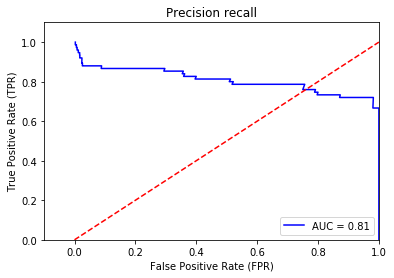

In [23]:
y_pred_numpy = prediciton_model(model, y_test, test_loader, X_test_tensor)
numpy.savetxt("SMOTE_C3_loc3.csv", y_pred_numpy, delimiter=",")

txt_plot = 'SMOTE_AUPCR_C3_loc3.png'
compute_aupcr(y_test, y_pred_numpy, txt_plot)

### Validation set

Average loss: 0.00386197
AUPCR score: 0.7933123967629698
[[56884    21]
 [   12    45]]


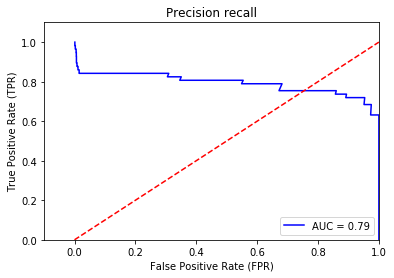

In [24]:
y_pred_numpy = prediciton_model(model, y_val, val_loader, X_val_tensor)
numpy.savetxt("SMOTE_C3_loc3_val.csv", y_pred_numpy, delimiter=",")

txt_plot = 'SMOTE_AUPCR_C3_loc3_val.png'
compute_aupcr(y_val, y_pred_numpy, txt_plot)

### Plot different AUC score against each other 

In [25]:
def compute_multiple_aupcr(y, collection_csv_files, txt_plot, legend):
    """ A function to plot several of AUPCR curve.
    IN: y (dataframe: either test- or validationset), collectio_csv_file (list of all y_pred_numpy)
    OUT: -
    """

    for index, y_pred in enumerate(collection_csv_files):
        fpr, tpr, threshold = metrics.precision_recall_curve(y,  y_pred)
        roc_auc = average_precision_score(y, y_pred)
        plt.plot(fpr, tpr, label = legend[index] + 'AUC = %0.2f' % roc_auc)
    
    plt.title('Precision recall')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.savefig(txt_plot)
    plt.show()

Same number of random clients

In [26]:
C_2_loc_2 = genfromtxt('SMOTE_C2_loc2.csv', delimiter=',')
C_2_loc_3 = genfromtxt('SMOTE_C2_loc3.csv', delimiter=',')
C2 = [C_2_loc_2, C_2_loc_3]

C_3_loc_2 = genfromtxt('SMOTE_C3_loc2.csv', delimiter=',')
C_3_loc_3 = genfromtxt('SMOTE_C3_loc3.csv', delimiter=',')
C3 = [C_3_loc_2, C_3_loc_3]

C_4_loc_2 = genfromtxt('SMOTE_C4_loc2.csv', delimiter=',')
C_4_loc_3 = genfromtxt('SMOTE_C4_loc3.csv', delimiter=',')
C4 = [C_4_loc_2, C_4_loc_3]

legend_loc_it = ['2 loc. it.', '3 loc. it.']

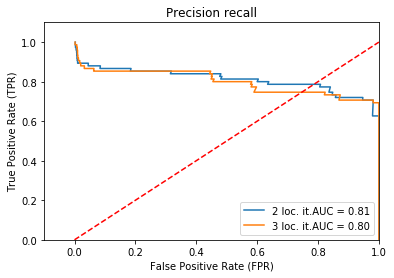

In [27]:
# 2 random clients
txt_plot = 'SMOTE_C2.png'
compute_multiple_aupcr(y_test, C2, txt_plot, legend_loc_it)

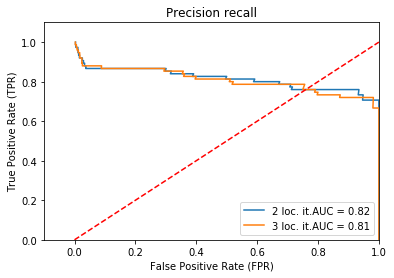

In [28]:
# 3 random clients
txt_plot = 'SMOTE_C3.png'
compute_multiple_aupcr(y_test, C3, txt_plot, legend_loc_it)

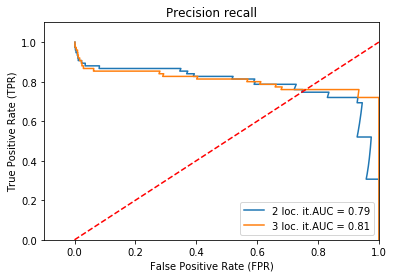

In [29]:
# 4 random clients
txt_plot = 'SMOTE_C4.png'
compute_multiple_aupcr(y_test, C4, txt_plot, legend_loc_it)

Same number of local iterations

In [30]:
C_2_loc_2 = genfromtxt('SMOTE_C2_loc2.csv', delimiter=',')
C_3_loc_2 = genfromtxt('SMOTE_C3_loc2.csv', delimiter=',')
C_4_loc_2 = genfromtxt('SMOTE_C4_loc2.csv', delimiter=',')
loc_2 = [C_2_loc_2, C_3_loc_2, C_4_loc_2]

C_2_loc_3 = genfromtxt('SMOTE_C2_loc3.csv', delimiter=',')
C_3_loc_3 = genfromtxt('SMOTE_C3_loc3.csv', delimiter=',')
C_4_loc_3 = genfromtxt('SMOTE_C4_loc3.csv', delimiter=',')
loc_3 = [C_2_loc_3, C_3_loc_2, C_4_loc_3]

legend_clients = ['2 rand. clients', '3 rand. clients', '4 rand. clients']

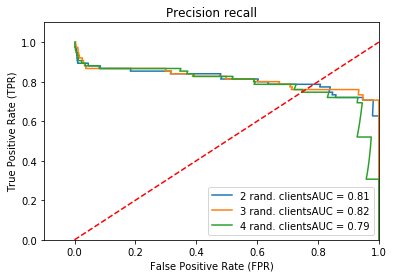

In [31]:
# 2 local iterations
txt_plot = 'SMOTE_loc2.png'
compute_multiple_aupcr(y_test, loc_2, txt_plot, legend_clients)

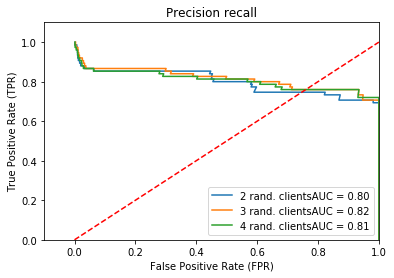

In [32]:
# 3 local iterations
txt_plot = 'SMOTE_loc3.png'
compute_multiple_aupcr(y_test, loc_3, txt_plot, legend_clients)

In [72]:


data_1 = genfromtxt('file1.csv', delimiter=',')
data_2 = genfromtxt('file2.csv', delimiter=',')

collection_csv_files = [data_1, data_2]
legend = ['2 loc. it.', '3 loc. it.']
txt_plot = 'test_all.png'
compute_aupcr(y_test, collection_csv_files, txt_plot, legend)

56962
56962


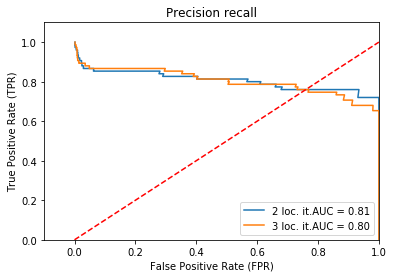

In [80]:
collection_csv_files = [my_data_1, my_data_2]
legend = ['2 loc. it.', '3 loc. it.']
txt_plot = 'test_all.png'
compute_aupcr(y_test, collection_csv_files, txt_plot, legend)